# Prediction pipeline

### Imports

In [52]:
import os
import sys
import cv2
import numpy as np
import glob
import json
import patchify
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow import keras
import skimage as ski
import re
import shutil

### Options and helpers

In [57]:
#target_dir = './perspective-correction-test/input_targets'
target_dir = './data_360/images'
image_size = (5760, 2880)
patch_size = 480
patches_horizontally = 2
patches_vertically = 4
rect_height = patch_size * patches_vertically # 1920
rect_width  = patch_size * patches_horizontally # 960 so one 5760px image fits in 5760 / 960 = 6 rectangles
equ_correction_steps = image_size[0] // rect_width
model_path = './2021-12-31-light-augments-val-loss-0_085'

label_rgbs = {
    "background": [0,0,0],
    "porras": [255,106,77],
    "portti": [51,221,255],
    "porttikäytävä": [255,204,51],
    "rapputunnus": [131,224,112],
    "sisäänkäynti": [61,61,245],
}

num_labels = len(label_rgbs.keys())
class_threshold = 0.8
min_bounding_box_size = 1000 # Theoretical max for 480x480 is 230400 pixels

def printr(value):
    print(' '*200, end="")
    print('\r', end="")
    print(value, end="")
    print('\r', end="")

### Perspective correction

In [3]:
class Equirectangular:
    def __init__(self, img_name):
        self._img = cv2.imread(img_name, cv2.IMREAD_COLOR)
        [self._height, self._width, _] = self._img.shape
    

    def GetPerspective(self, FOV=0, THETA=0, PHI=0, height=0, width=0):
        #
        # THETA is left/right angle, PHI is up/down angle, both in degree
        #

        equ_h = self._height
        equ_w = self._width
        equ_cx = (equ_w - 1) / 2.0
        equ_cy = (equ_h - 1) / 2.0

        wFOV = FOV
        hFOV = float(height) / width * wFOV

        w_len = np.tan(np.radians(wFOV / 2.0))
        h_len = np.tan(np.radians(hFOV / 2.0))


        x_map = np.ones([height, width], np.float32)
        y_map = np.tile(np.linspace(-w_len, w_len,width), [height,1])
        z_map = -np.tile(np.linspace(-h_len, h_len,height), [width,1]).T

        D = np.sqrt(x_map**2 + y_map**2 + z_map**2)
        xyz = np.stack((x_map,y_map,z_map),axis=2)/np.repeat(D[:, :, np.newaxis], 3, axis=2)
        
        y_axis = np.array([0.0, 1.0, 0.0], np.float32)
        z_axis = np.array([0.0, 0.0, 1.0], np.float32)
        [R1, _] = cv2.Rodrigues(z_axis * np.radians(THETA))
        [R2, _] = cv2.Rodrigues(np.dot(R1, y_axis) * np.radians(-PHI))

        xyz = xyz.reshape([height * width, 3]).T
        xyz = np.dot(R1, xyz)
        xyz = np.dot(R2, xyz).T
        lat = np.arcsin(xyz[:, 2])
        lon = np.arctan2(xyz[:, 1] , xyz[:, 0])

        lon = lon.reshape([height, width]) / np.pi * 180
        lat = -lat.reshape([height, width]) / np.pi * 180

        lon = lon / 180 * equ_cx + equ_cx
        lat = lat / 90  * equ_cy + equ_cy

        
            
        persp = cv2.remap(self._img, lon.astype(np.float32), lat.astype(np.float32), cv2.INTER_CUBIC, borderMode=cv2.BORDER_WRAP)
        return persp

    
def perspective_correction(input_path, output_folder, steps=6):
    """
    FOV unit is degree
    theta is z-axis angle(right direction is positive, left direction is negative)
    phi is y-axis angle(up direction positive, down direction negative)
    height and width is output image dimension
    """
    
    filename = input_path.split("/")[-1].split(".")[:-1][0]
    if output_folder[-1] == '/':
        output_folder = output_folder[:-1]

    equ = Equirectangular(input_path)

    step = 360 // steps
    filepaths = []
    for i in range(0, 360, step):
        img = equ.GetPerspective(FOV=step, THETA=i, PHI=0, height=rect_height, width=rect_width)
        i_str = str(i).zfill(3)
        i_step_str = str(i+step).zfill(3)
        output = f'{output_folder}/{filename}-degrees-{i_str}-{i_step_str}.png'
        cv2.imwrite(output, img)
        filepaths.append(output)
    return filepaths
        

### Make patches

In [4]:
def create_patches_prime(filepath):
    img = Image.open(filepath)
    patches_in_column = rect_height // patch_size
    patches_in_row = rect_width // patch_size
    img_patched = patchify.patchify(np.asarray(img), (patch_size, patch_size, 3), step=patch_size).reshape(patches_in_column * patches_in_row, patch_size, patch_size, 3)
    filepaths = []
    for i in range(0, img_patched.shape[0]):
        outfilepath = f'{".".join(filepath.split(".")[:-1])}-{str(i).zfill(2)}.npz'
        np.savez_compressed(outfilepath, img_patched[i])
        filepaths.append(outfilepath)
    return filepaths

def create_patches(perspective_corrected_filepaths):
    npz_filepaths = []
    for perspective_corrected_filepath in perspective_corrected_filepaths:
        npz_filepaths_prime = create_patches_prime(perspective_corrected_filepath)
        npz_filepaths += npz_filepaths_prime
    return npz_filepaths


### Predict

In [5]:
def predict_with(model, patched_npz_filepaths):
    outfilepaths = []
    for filepath in patched_npz_filepaths:
        outfilepath = f'{".".join(filepath.split(".")[:-1])}-prediction.npz'
        x = np.asarray([np.load(filepath)['arr_0'] / 255]) # Keras expects a batch
        y = model.predict(x, batch_size=1)
        np.savez_compressed(outfilepath, y)
        outfilepaths.append(outfilepath)
    return outfilepaths

### Stich back to 60 degrees images

In [6]:
def stich_back_single(folder, filename):
    target_filename_without_extension = ".".join(filename.split(".")[:-1])
    prediction_filenames = sorted([filename for filename in os.listdir(folder) if target_filename_without_extension in filename and "-prediction" in filename and "-prediction-full" not in filename])
    canvas = np.zeros([rect_height, rect_width, num_labels])
    for i, prediction_filename in enumerate(prediction_filenames):
        # Calculate proper point to insert prediction
        row = i // patches_horizontally
        column = i % patches_horizontally
        start_row_idx = row * patch_size
        end_row_idx = (row + 1) * patch_size
        start_column_idx = column * patch_size
        end_column_idx = (column + 1) * patch_size
        
        # Load and insert prediction
        prediction = np.load(f'{folder}/{prediction_filename}')['arr_0'].reshape(patch_size, patch_size, num_labels)
        canvas[start_row_idx:end_row_idx, start_column_idx:end_column_idx] = prediction
        
    outfilepath = f'{folder}/{target_filename_without_extension}-prediction-full.npz'
    np.savez_compressed(outfilepath, canvas)
    return outfilepath
        
def stich_back(perspective_corrected_filepaths):
    outfilepaths = []
    
    for filepath in perspective_corrected_filepaths:
        filepath_parts = filepath.split("/")
        folder = "/".join(filepath_parts[:-1])
        filename = filepath_parts[-1]
        outfilepath = stich_back_single(folder, filename)
        outfilepaths.append(outfilepath)
        
    return outfilepaths

# Get bounding boxes

In [12]:
def get_bounding_box(filepath, orig_filename, start_degree, end_degree):
    stiched_pred = np.load(filepath)['arr_0']
    boxes = []
    for cls_idx, cls_name in enumerate(label_rgbs):
        if cls_name == 'background':
            continue
        target = stiched_pred[:,:,cls_idx] 
        target = target > class_threshold
        target = ski.morphology.closing(target, ski.morphology.square(20))
        label_target = ski.measure.label(target, connectivity=2)
        regions = ski.measure.regionprops(label_target)
        
        for props in regions:
            minr, minc, maxr, maxc = props.bbox
            boxsize = (maxr-minr) * (maxc-minc)
            if boxsize > min_bounding_box_size:
                max_degrees = end_degree - start_degree
                degrees_start = start_degree + (minc / rect_width  * max_degrees)
                degrees_end = start_degree + (maxc / rect_width * max_degrees)
                boxes.append({ 'filename': orig_filename, 'class': cls_name, 'degrees': (degrees_start, degrees_end)})
    return boxes

def get_bounding_boxes(stiched_prediction_filepaths):
    boxes = []
    for filepath in stiched_prediction_filepaths:
        orig_filename = f'{filepath.split("/")[-1].split("-degrees")[0]}.JPG'
        pattern = re.compile('.*-degrees-(\d{3})-(\d{3})-prediction.*')
        res = re.match(pattern, filepath)
        start_degree = int(res.group(1))
        end_degree = int(res.group(2))
        new_boxes = get_bounding_box(filepath, orig_filename, start_degree, end_degree)
        boxes = boxes + new_boxes
    return boxes

# Run the whole thing

In [16]:
target_folder_split = target_dir.split("/")
temp_folder_name='temp'
target_folder_parent = "/".join(target_folder_split[:-1])
f'{target_folder_parent}/{temp_folder_name}'

'./temp'

In [ ]:
def run_pipeline(target_folder, temp_folder_name='temp', clean=True):
    printr('Initializing...')
    # normalize target folder
    if target_folder[-1] == '/':
        target_folder = target_folder[:-1]
    
    # create temp folder
    target_folder_split = target_folder.split("/")
    target_folder_parent = "/".join(target_folder_split[:-1])
    output_folder = f'{target_folder_parent}/{temp_folder_name}'
    
    model = keras.models.load_model(model_path)
    
    # setup
    filenames = [filename for filename in os.listdir(target_folder) if '.JPG' in filename]
    filenames_n = len(filenames)
    filenames_digits = len(str(filenames_n))
    
    print(f'Total number of files: {filenames_n}')
    printr(f'Done: {"0".zfill(filenames_digits)}/{filenames_n}')
    # The Pipeline
    for i, filename in enumerate(filenames):
        if temp_folder_name not in os.listdir(target_folder_parent):
            os.mkdir(output_folder)
        full_path = f'{target_dir}/{filename}'
        printr(f'Done: {i}/{filenames_n}, correcting perspective...')
        perspective_corrected_filepaths = perspective_correction(full_path, output_folder)
        printr(f'Done: {i}/{filenames_n}, creating patches...')
        patched_npz_filepaths = create_patches(perspective_corrected_filepaths)
        printr(f'Done: {i}/{filenames_n}, running prediction...')
        prediction_filepaths = predict_with(model, patched_npz_filepaths)
        printr(f'Done: {i}/{filenames_n}, stiching prediction back...')
        stiched_back_filepaths = stich_back(perspective_corrected_filepaths)
        printr(f'Done: {i}/{filenames_n}, calculating degrees...')
        new_degrees = get_bounding_boxes(stiched_back_filepaths)
        printr(f'Done: {str(i+1).zfill(filenames_digits)}/{filenames_n}')
        with open(f'./results/{filename}.json', 'w+') as outfile:
            json.dump(res, outfile)
        if clean:
            shutil.rmtree(output_folder)
    print('Done!')
res = run_pipeline(target_dir)

Total number of files: 10866                                                                                                                                                                            


In [55]:
shutil.rmtree('./temp')

In [11]:
with open('./demo-reults', 'w+') as outfile:
    json.dump(res, outfile)

### Tests

patchify

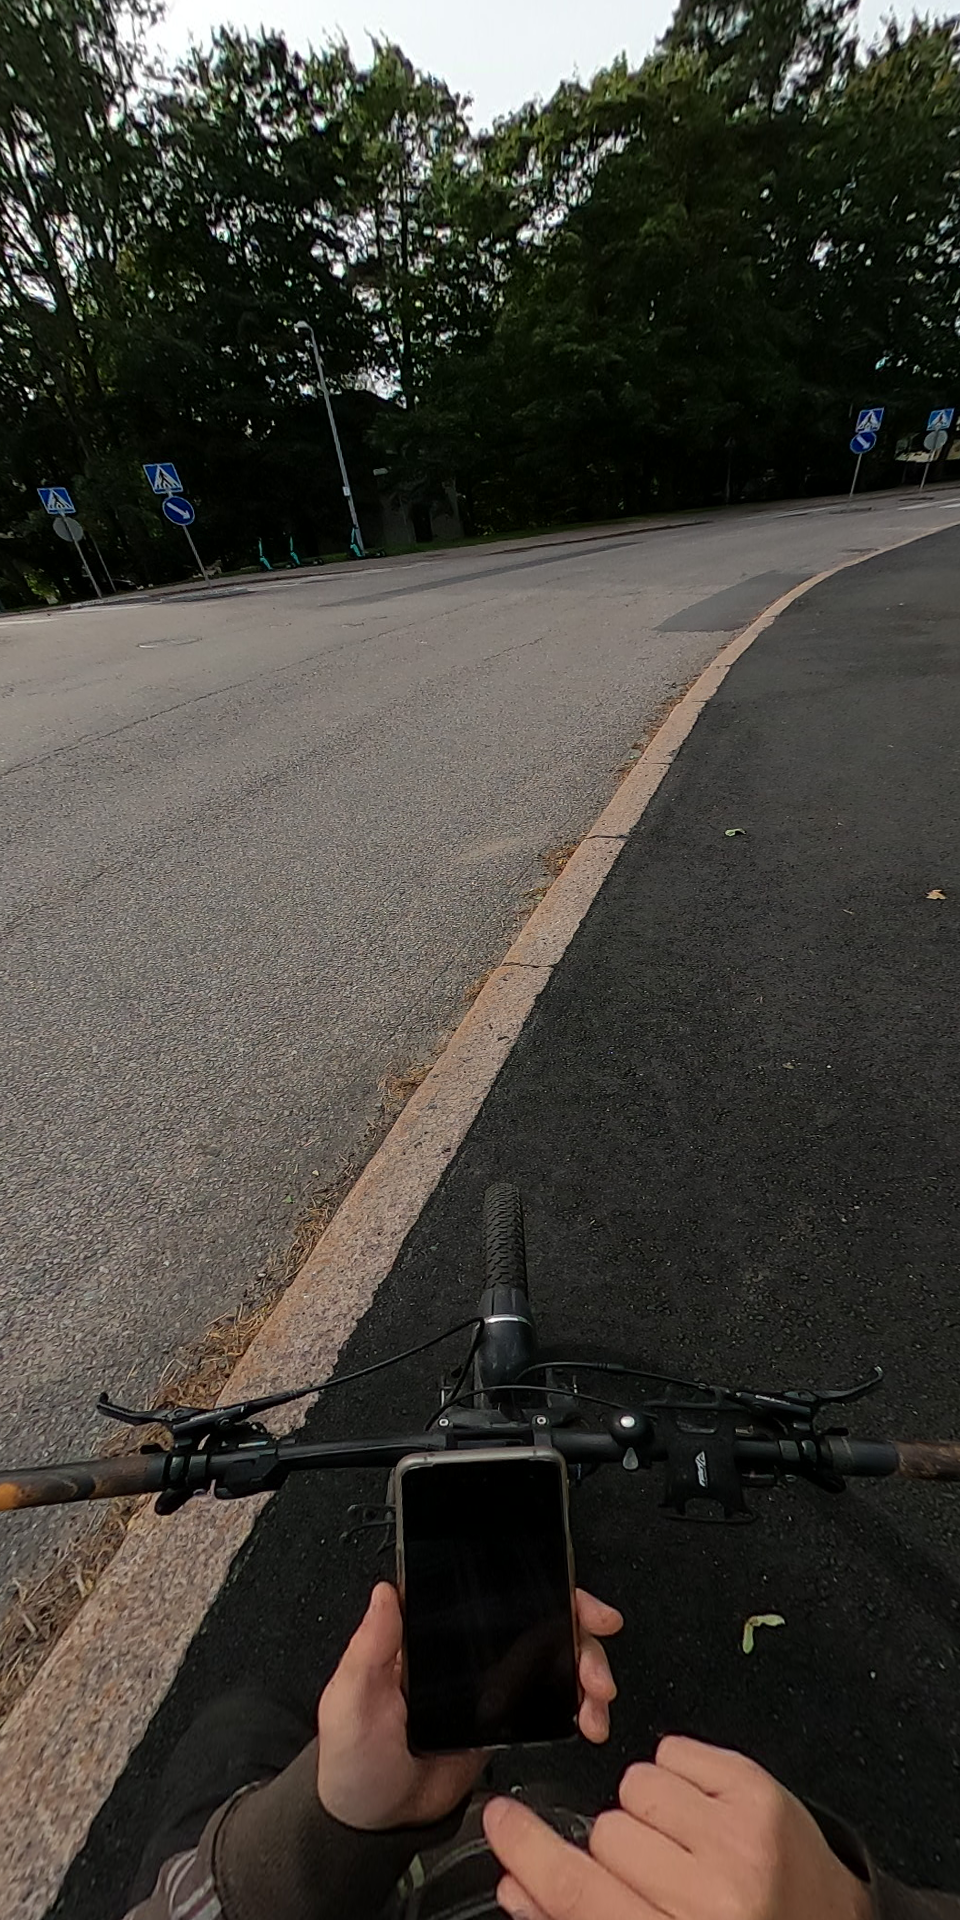

In [137]:
tempfolder = './perspective-correction-test/temp' 
testimage_name = '20210914-kruununhaka_GSAD0170_000-060.png'
testimg = Image.open(f'{tempfolder}/{testimage_name}')
testimg

In [62]:
patch_filenames = sorted([npz for npz in os.listdir(tempfolder) if '.npz' in npz and 'prediction' not in npz and '.'.join(testimage_name.split('.')[:-1]) in npz])
patches = [np.load(f'{tempfolder}/{npz}')['arr_0'] for npz in patch_filenames]
patch_filenames

['20210914-kruununhaka_GSAD0170_000-060-00.npz',
 '20210914-kruununhaka_GSAD0170_000-060-01.npz',
 '20210914-kruununhaka_GSAD0170_000-060-02.npz',
 '20210914-kruununhaka_GSAD0170_000-060-03.npz',
 '20210914-kruununhaka_GSAD0170_000-060-04.npz',
 '20210914-kruununhaka_GSAD0170_000-060-05.npz',
 '20210914-kruununhaka_GSAD0170_000-060-06.npz',
 '20210914-kruununhaka_GSAD0170_000-060-07.npz']

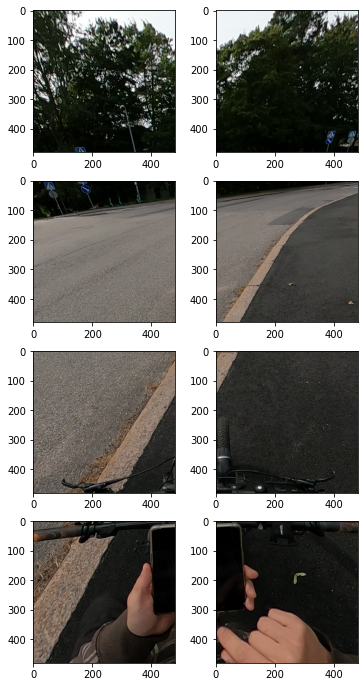

In [63]:
n_rows = 4
n_columns = 2
fig, axs = plt.subplots(n_rows, n_columns, figsize=(n_columns*3, n_rows*3))
for i in range(0, n_rows):
    for j in range(0, n_columns):
        idx = i*n_columns + j
        axs[i][j].imshow(patches[idx])

# Check predictions

In [56]:
testfile = '20210914-kruununhaka_GSAD0170_000-060'
testfolder = './perspective-correction-test/temp'

X_paths = sorted([f'{testfolder}/{npz}' for npz in os.listdir(testfolder) if testfile in npz and 'prediction' not in npz and '.npz' in npz])
y_paths = sorted([f'{testfolder}/{npz}' for npz in os.listdir(testfolder) if testfile in npz and 'prediction' in npz and '.npz' in npz])
X = [np.load(x_path)['arr_0'] for x_path in X_paths]
res = [np.load(y_path)['arr_0'].reshape(480, 480, 6) for y_path in y_paths]
preds = zip(X,y)

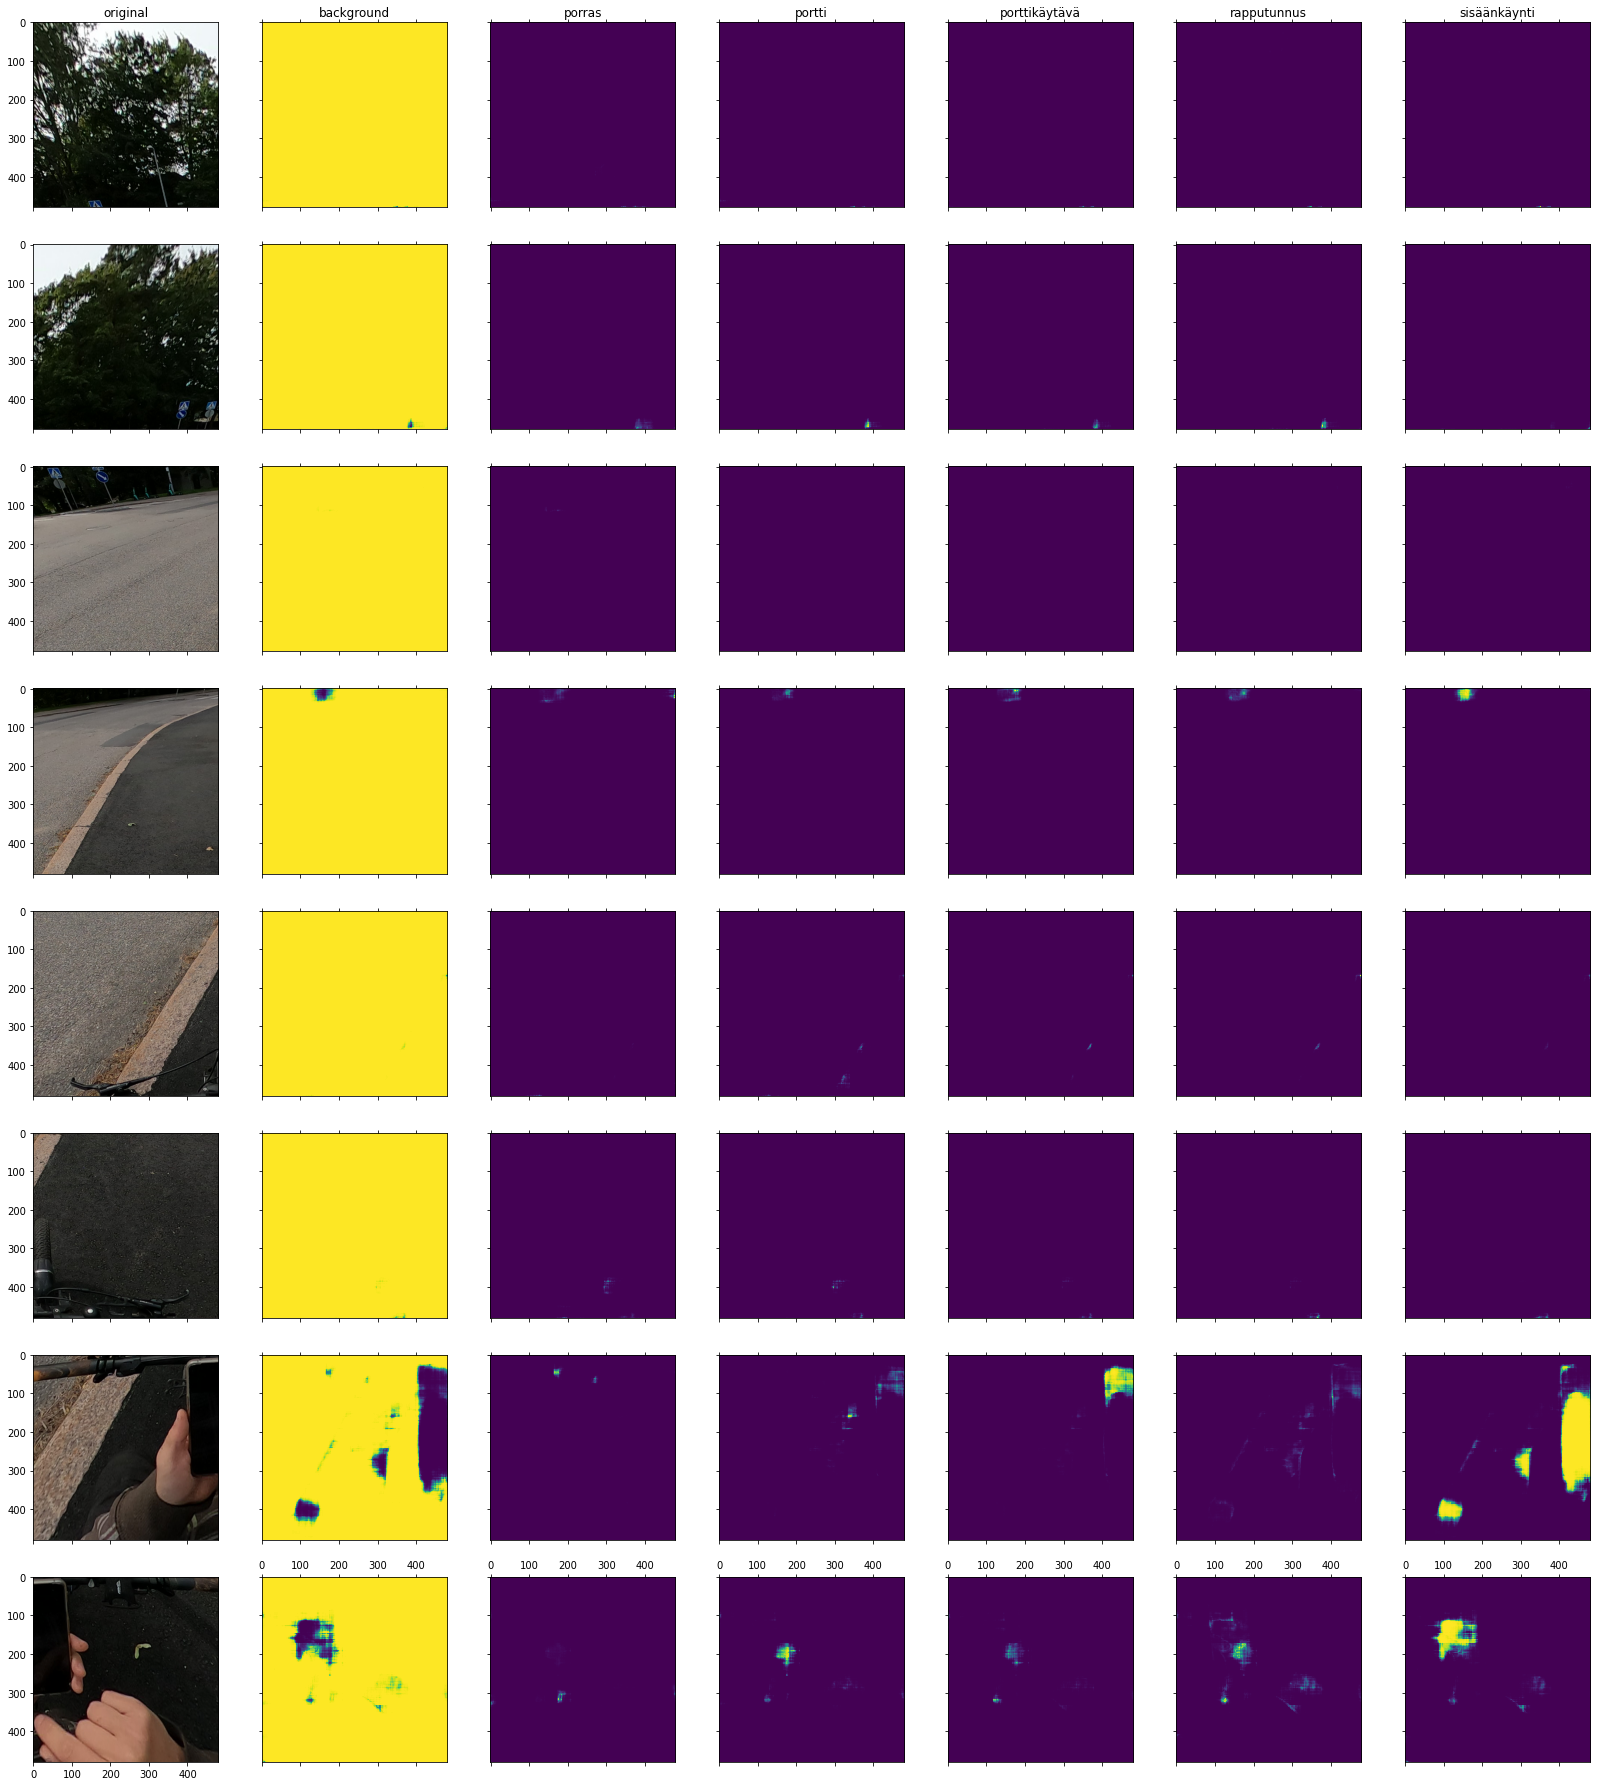

In [57]:
n = len(X)
fig, axs = plt.subplots(n, 7, figsize=(7*4, n*4), sharex=True, sharey=True)

axs[0][0].set_title('original')
for i, key in enumerate(label_rgbs.keys()):
    axs[0][i + 1].set_title(key)

for j in range(0, n):
    axs[j][0].imshow(X[j])

for i in range(1, 7):
    for j in range(0, n):
        axs[j][i].matshow(res[j][:,:,i-1])    

In [40]:
start = 12

In [50]:
import glob
n = 3
start = start + n
class_treshold = 0.8
target_filenames = glob.glob('./temp/*.png')[start:start + n]
prediction_filenames = [target.replace('.png', '-prediction-full.npz') for target in target_filenames]

targets = [Image.open(target) for target in target_filenames]
predictions = [np.load(prediction)['arr_0'] > class_treshold for prediction in prediction_filenames]

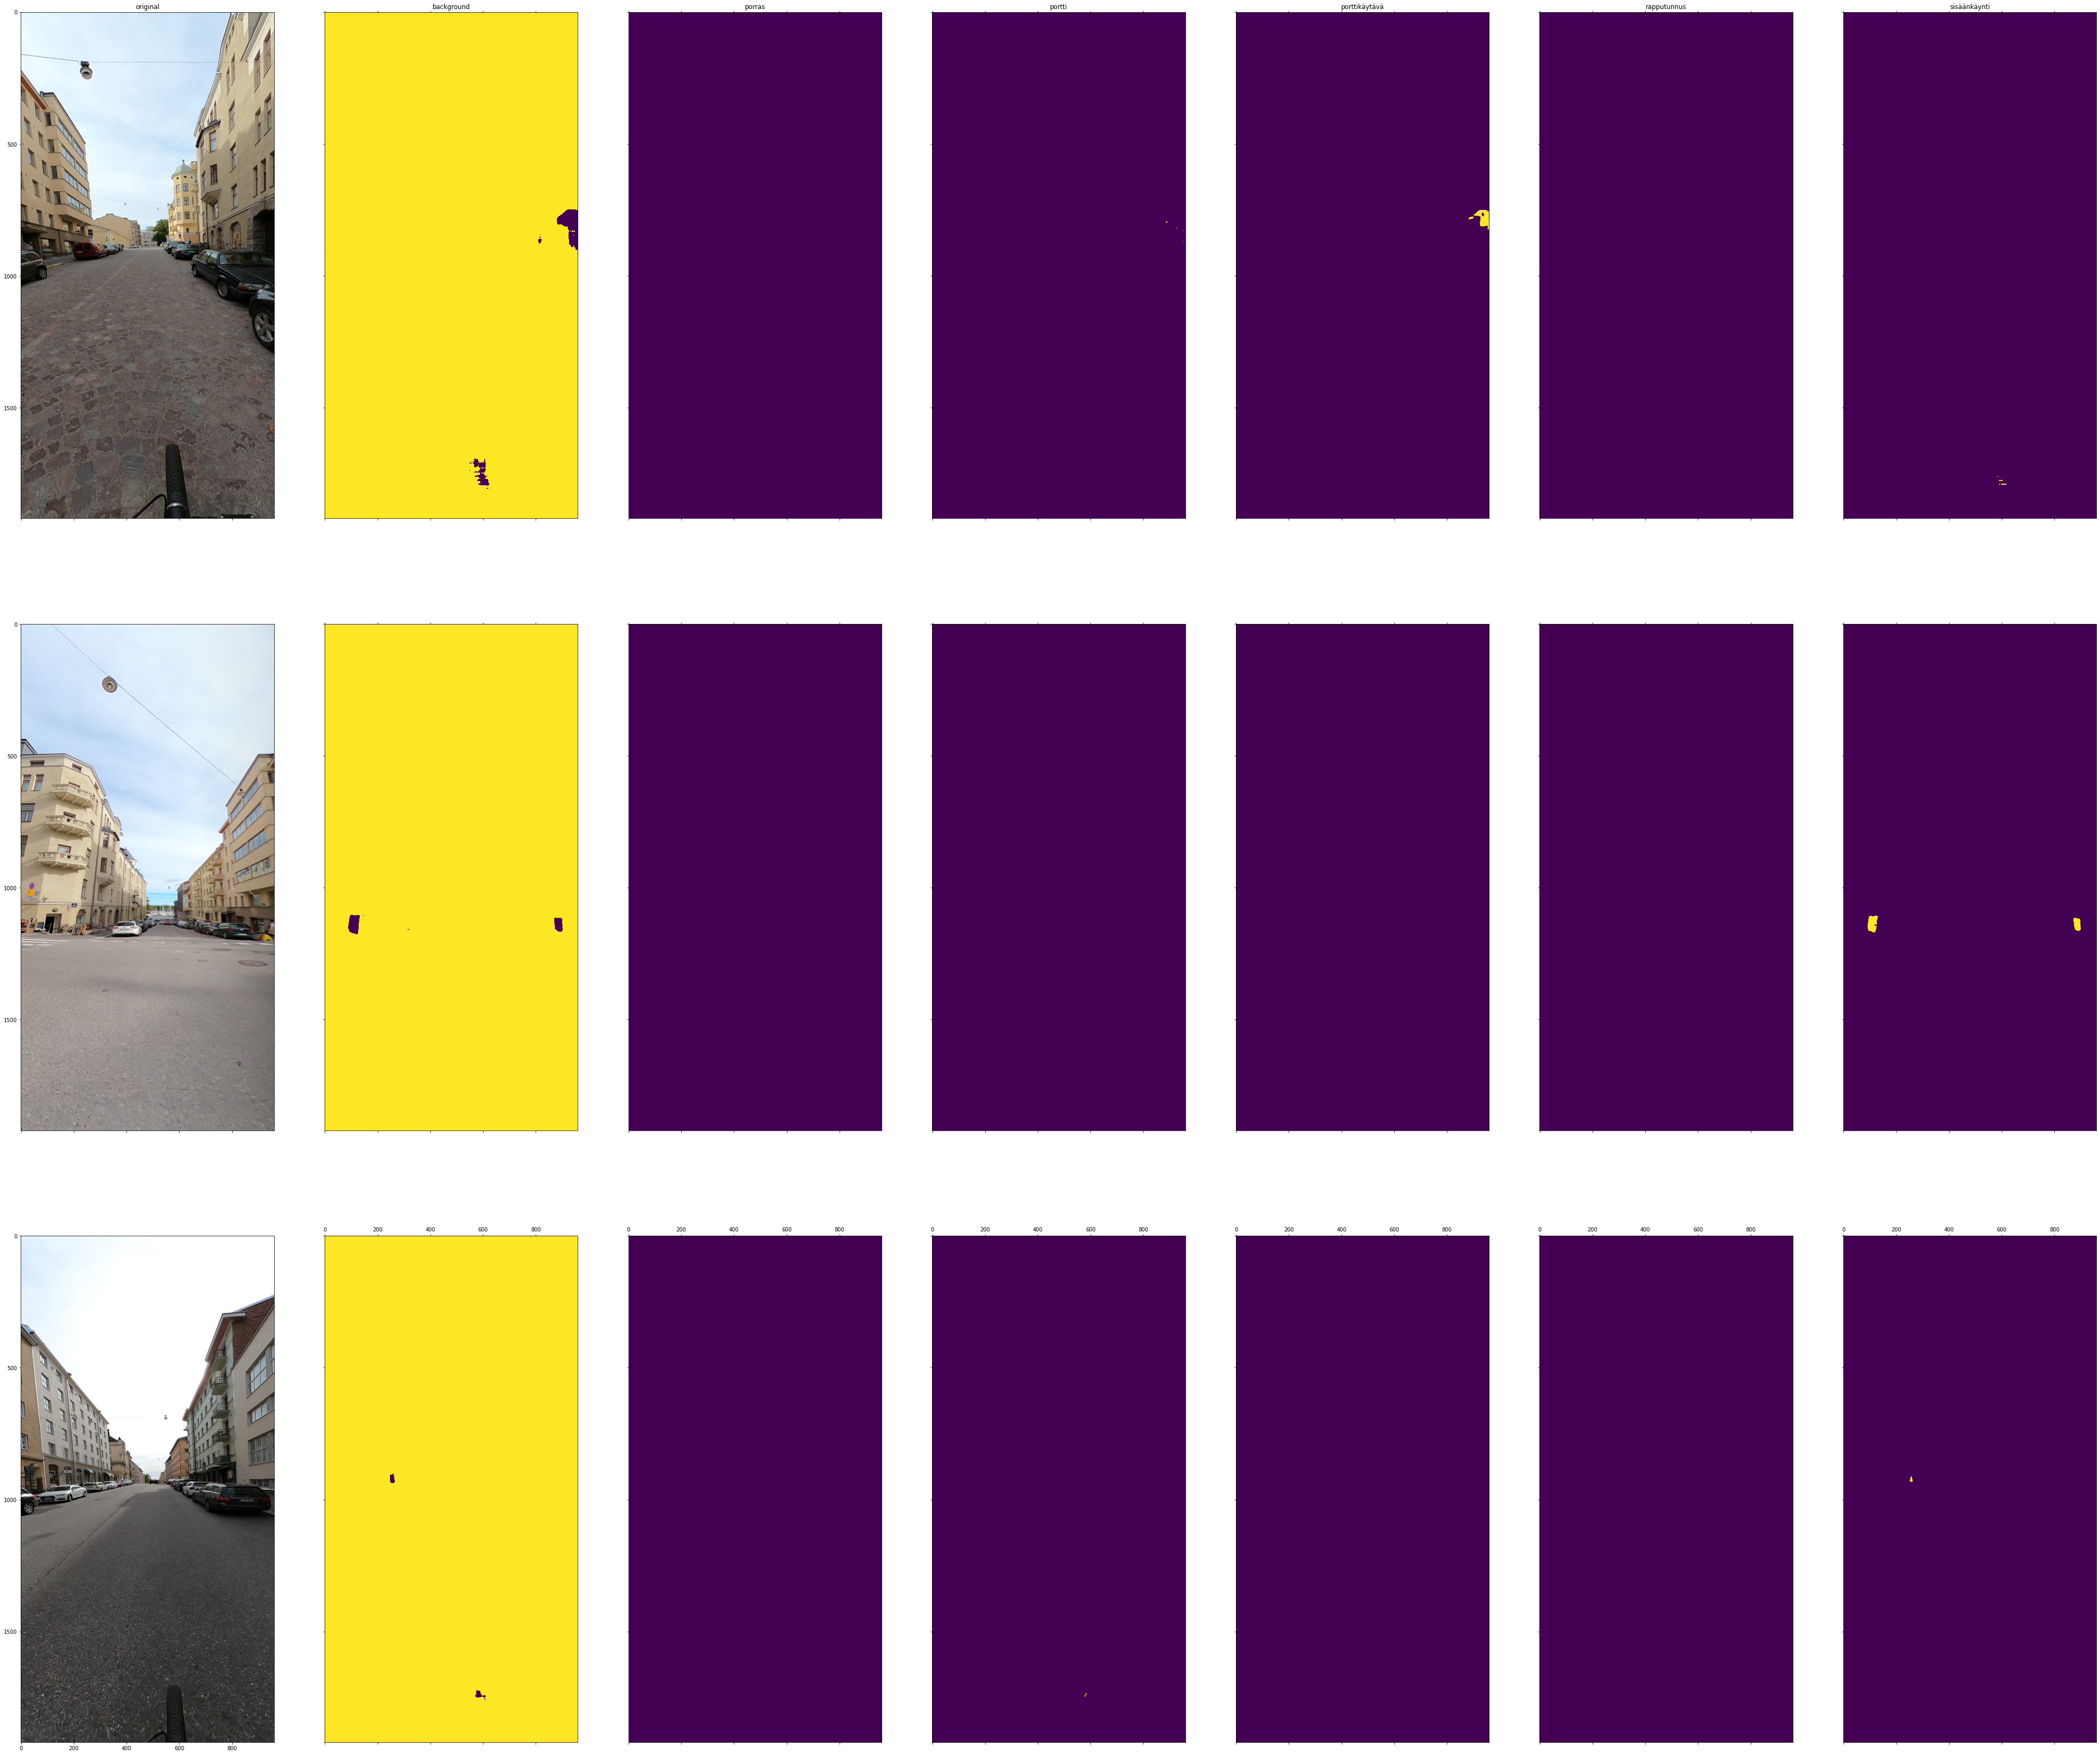

In [51]:
fig, axs = plt.subplots(n, 7, figsize=(7*10, n*20), sharex=True, sharey=True)

axs[0][0].set_title('original')
for i, key in enumerate(label_rgbs.keys()):
    axs[0][i + 1].set_title(key)

for j in range(0, n):
    axs[j][0].imshow(targets[j])

for i in range(1, 7):
    for j in range(0, n):
        axs[j][i].matshow(predictions[j][:,:,i-1])    

In [31]:
filepath = '.perspective-correction-test/some-file.png'
i=0

In [32]:
f'{".".join(filepath.split(".")[:-1])}-{str(i).zfill(2)}.npz'

'perspective-correction-test/some-file-00.npz'

In [13]:
5760/480

12.0

In [14]:
5760 / 6

960.0

In [15]:
1920 / 480

4.0

Generator for predictions (probably hard to keep track of which prediction this is...)

In [27]:

class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs=[], batch_size=2):
        self.list_IDs = list_IDs
        self.batch_size = batch_size
        
        
    def __len__(self):
        n_items = len(self.list_IDs)
        at_least = n_items // self.batch_size
        if n_items % self.batch_size == 0:
            return at_least
        return at_least + 1
    
    def __getitem__(self, index):
        start = self.batch_size * index
        end = self.batch_size * (index + 1)
        IDs = self.list_IDs[start:end]
        np_arrs = np.asarray([np.load(arr)['arr_0'] / 255 for arr in IDs])
        return np_arrs
    
    
def predict_with(model, batch_size):
    def predict(npz_filepaths):
        gen = DataGenerator(batch_size=batch_size, list_IDs=npz_filepaths)
        results = model.predict(gen)
        return results
    return predict



['./perspective-correction-test/temp/20210914-kruununhaka_GSAD0170-degrees-000-060-prediction-full.npz',
 './perspective-correction-test/temp/20210914-kruununhaka_GSAD0220-degrees-120-180-prediction-full.npz',
 './perspective-correction-test/temp/20210914-kruununhaka_GSAD0220-degrees-180-240-prediction-full.npz',
 './perspective-correction-test/temp/20210914-kruununhaka_GSAD0170-degrees-060-120-prediction-full.npz',
 './perspective-correction-test/temp/20210914-kruununhaka_GSAD0220-degrees-300-360-prediction-full.npz',
 './perspective-correction-test/temp/20210914-kruununhaka_GSAD0220-degrees-240-300-prediction-full.npz',
 './perspective-correction-test/temp/20210914-kruununhaka_GSAD0170-degrees-300-360-prediction-full.npz',
 './perspective-correction-test/temp/20210914-kruununhaka_GSAD0220-degrees-060-120-prediction-full.npz',
 './perspective-correction-test/temp/20210914-kruununhaka_GSAD0220-degrees-000-060-prediction-full.npz',
 './perspective-correction-test/temp/20210914-kruununha

In [330]:
filepaths = glob.glob('./perspective-correction-test/temp/*prediction-full.npz')
preds = [np.load(filepath)['arr_0'] for filepath in filepaths]

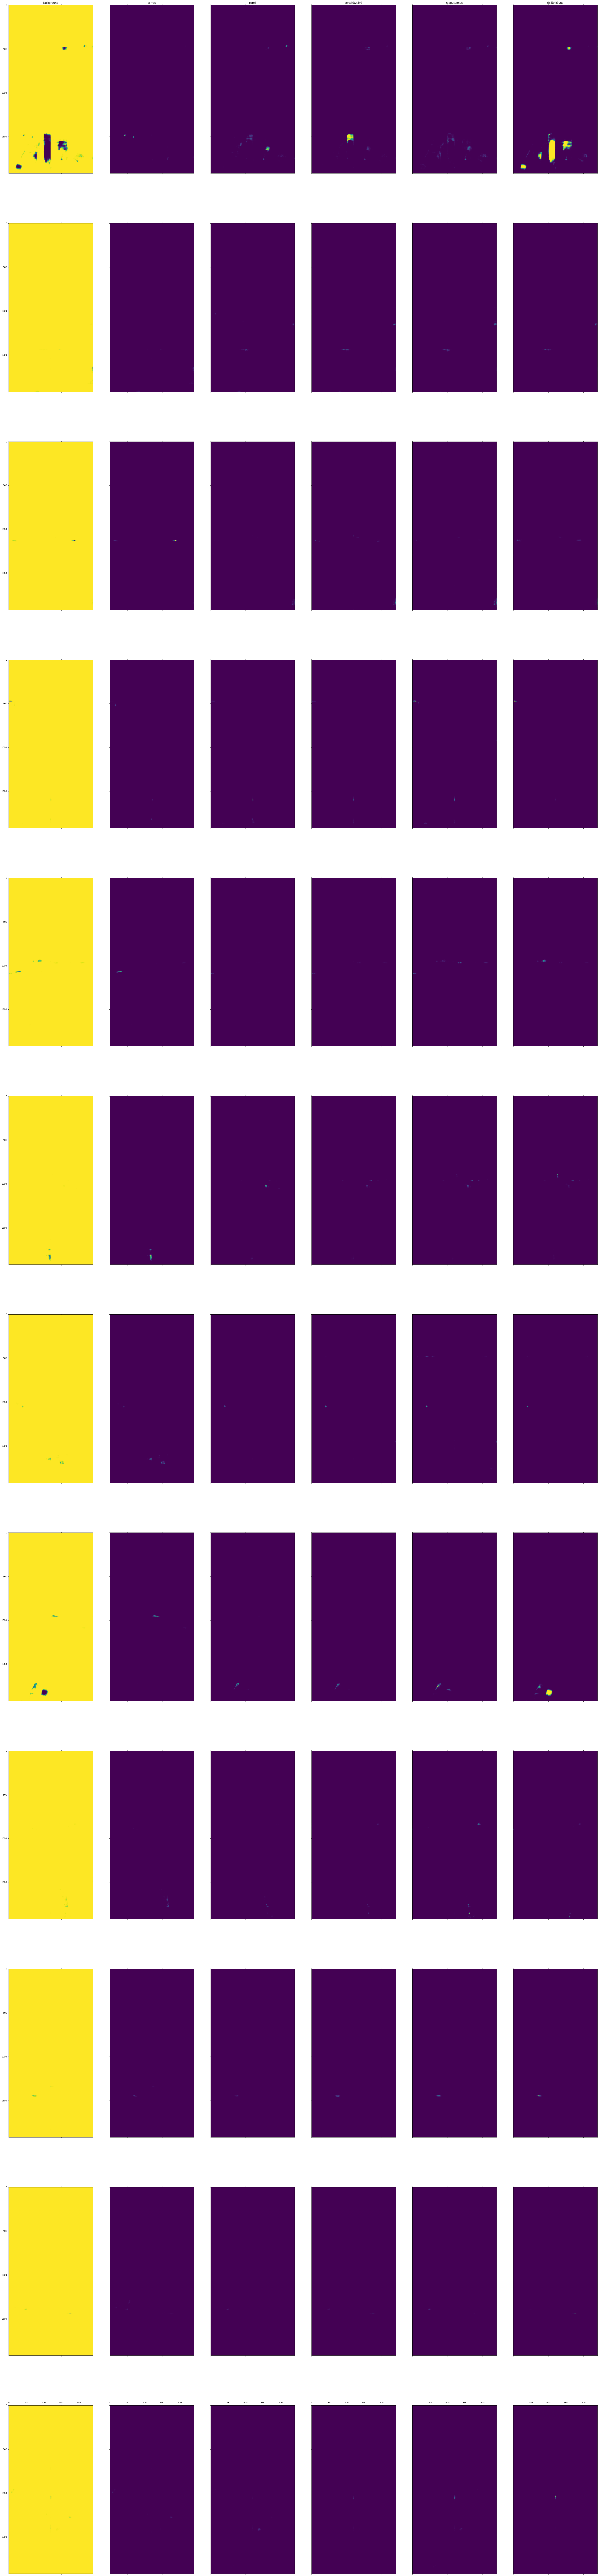

In [332]:
n = len(preds)
n_classes = 6
fig, axs = plt.subplots(n, n_classes, figsize=(n*4, n*18), sharex=True, sharey=True)

for i, key in enumerate(label_rgbs.keys()):
    axs[0][i].set_title(key)

for i in range(0, n_classes):
    for j in range(0, n):
        axs[j][i].matshow(preds[j][:,:,i])    

In [359]:
os.listdir('./perspective-correction-test/input_targets')

['20210914-kruununhaka_GSAD0170.JPG',
 '.ipynb_checkpoints',
 '20210914-kruununhaka_GSAD0220.JPG']

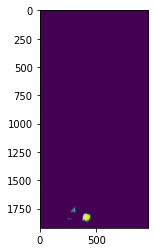

In [335]:
#target = stiched_pred[:,:,5]
target = preds[7][:,:,5]
plt.imshow(target)

Number of labels: 2


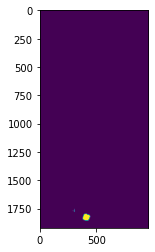

In [336]:
target_orig = target
target = target > 0.8
target = ski.morphology.closing(target, ski.morphology.square(20))
label_target, num_labels = ski.measure.label((target > class_threshold), connectivity=2, return_num=True)
print(f'Number of labels: {num_labels}')
plt.imshow(label_target)

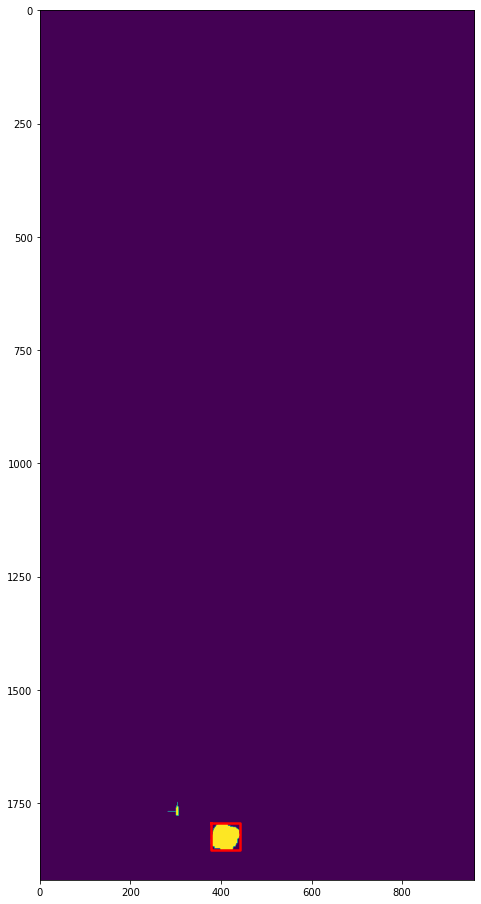

In [337]:
regions = regionprops(label_target)
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(target)

for props in regions:
    minr, minc, maxr, maxc = props.bbox
    boxsize = (maxr-minr) * (maxc-minc)
    if boxsize > min_bounding_box_size:
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax.plot(bx, by, '-r', linewidth=2.5)


In [163]:
from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate

In [174]:
image = np.zeros((600, 600))

rr, cc = ellipse(300, 350, 100, 220)
image[rr, cc] = 1

image = rotate(image, angle=15, order=0)

rr, cc = ellipse(100, 100, 60, 50)
image[rr, cc] = 1


image.dtype

#label_img = label(image)
#regions = regionprops(label_img)

#regions

dtype('float64')